## Performance across climate space
- for G x M combinations that either improved or declined in performance rankings
- for different top-performing strategy groups under present vs. future climate

In [ ]:
from ideotype.figures import (plot_yield_sensitivity_lines,
                              plot_yield_sensitivity_heatmap,
                              plot_cspace_sites_map,
                              plot_cspace_sites_scatter,
                              plot_strategies_performance_cspace,
                              plot_strategies_performance_shift_cspace)

### Yield sensitivity (% yield loss per degree C warming)
- a) PDF of yield sensitivity between G x M combinations that improved in performance rankings (purple) vs. those that declined (orange)
- b) Yield sensitivity across climatological temperature across sites. Cooler sites (<0 values on x-axis) vs. warmer sites (>0 values on x-axis)

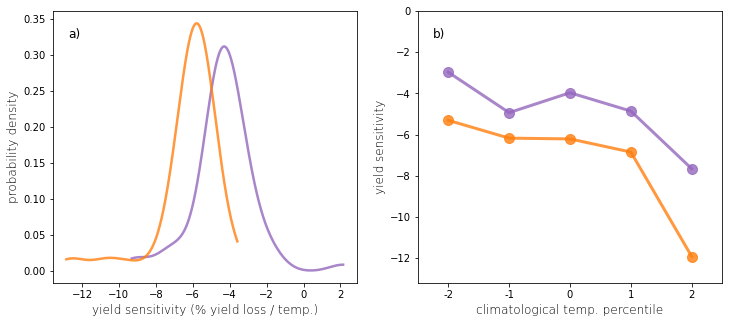

In [3]:
plot_yield_sensitivity_lines()

Detailed yield sensitivity across temperature & precip space for:
- a) G x M combinations that improved in ranking, versus 
- b) G x M combinations that declined in rankings

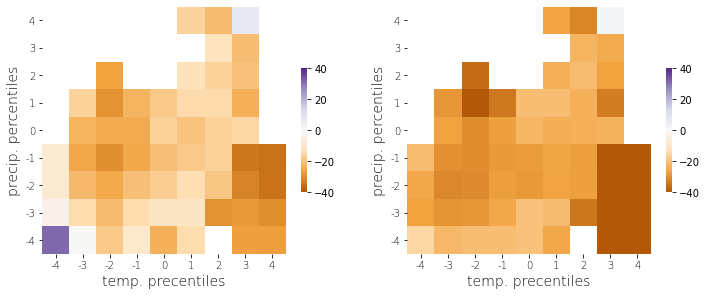

In [3]:
plot_yield_sensitivity_heatmap()

### Cluster simulation sites into climate space
(see analys_cspace_cluster.ipynb clustering code)

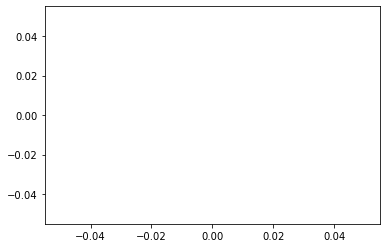

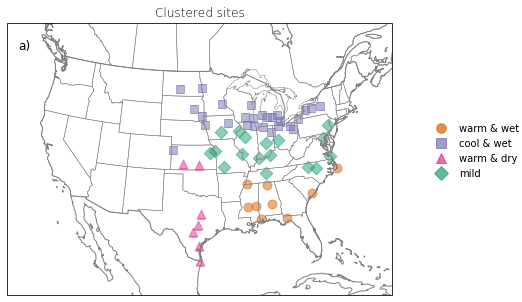

In [7]:
plot_cspace_sites_map('present')

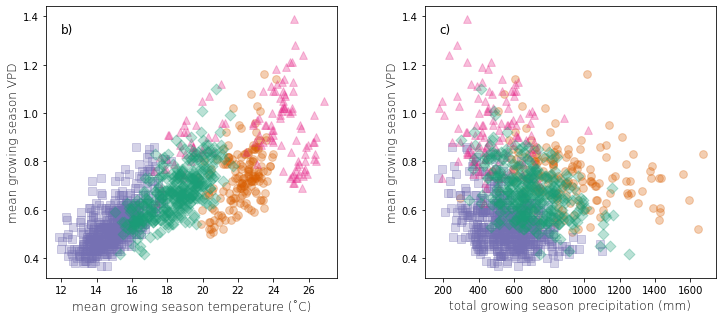

In [3]:
plot_cspace_sites_scatter('present')

### Standardized performance of top-performing strategies across climate space

Present climate:

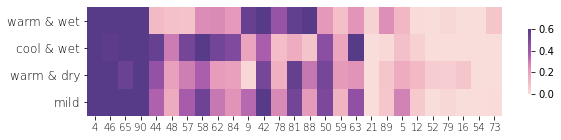

In [2]:
plot_strategies_performance_cspace('present')

Future climate (2100):

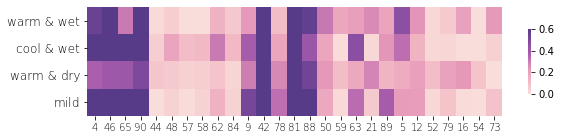

In [3]:
plot_strategies_performance_cspace('f2100')

Difference between present & 2100:

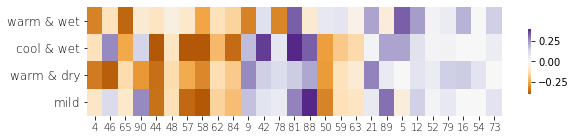

In [2]:
plot_strategies_performance_shift_cspace()

vvv still cleaning up code vvv

In [5]:
from numpy import linspace
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats.kde import gaussian_kde

from palettable.matplotlib import Magma_10
from palettable.colorbrewer.sequential import YlGn_9
from palettable.colorbrewer.sequential import YlOrRd_6
from palettable.colorbrewer.sequential import GnBu_8
from palettable.colorbrewer.sequential import OrRd_6
from palettable.colorbrewer.diverging import PuOr_7
from palettable.cartocolors.sequential import PurpOr_6
from palettable.cartocolors.sequential import RedOr_6
from palettable.cartocolors.qualitative import Vivid_4
from palettable.colorbrewer.qualitative import Dark2_4

from ideotype.data_process import (read_data,
                                   fetch_norm_mean_disp,
                                   fetch_mean_disp_diff,
                                   fetch_sim_values,
                                   fetch_sens)
from ideotype.analysis import (rank_top_phenos, 
                               identify_top_phenos,
                               identify_improved_phenos, 
                               identify_rankchanged_phenos,
                               phenostage_climate)
from ideotype.figures import (plot_rankchange,
                              plot_params_heatmap,
                              plot_cspace_rank,
                              plot_cspace_yield,
                              plot_mean_disp_change)
from ideotype.init_params import params_sample
from ideotype.data_process import parse_mature
from ideotype import DATA_PATH

In [10]:
# Read in present-day data
run_name = 'present'
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    f'/home/disk/eos8/ach315/ideotype/ideotype/'
    f'data/files/filepaths_{run_name}.yml')
df_extended, df_stuck = parse_mature(df_all)
df_all.drop(df_stuck.index, inplace=True)
df_all.site = df_all.site.astype(int)

In [11]:
df_climate = df_all.groupby('site').mean()[['temp', 'vpd', 'precip']]
df_climate_std = StandardScaler().fit_transform(df_climate)
df_climate.reset_index(inplace=True)

kmeans_mod = KMeans(n_clusters=4)
kmeans_mod.fit(df_climate_std)
y_kmeans = kmeans_mod.predict(df_climate_std)

df_cluster = df_climate.copy()
df_cluster['group'] = y_kmeans

df_km0 = df_cluster.query('group==0')
df_km1 = df_cluster.query('group==1')
df_km2 = df_cluster.query('group==2')
df_km3 = df_cluster.query('group==3')

df_sites.site = df_sites.site.astype(int)
df_clustered_sites = pd.merge(df_cluster, df_sites, left_on='site', right_on='site')
#df_clustered_sites.to_csv('/home/disk/eos8/ach315/ideotype/ideotype/data/climate_cluster/sites_clusered.csv', index=False)

df_clustered_sites = pd.read_csv('/home/disk/eos8/ach315/ideotype/ideotype/data/climate_cluster/sites_clusered.csv')
df_km0_sites = pd.merge(df_km0, df_sites, on='site')
df_km1_sites = pd.merge(df_km1, df_sites, on='site')
df_km2_sites = pd.merge(df_km2, df_sites, on='site')
df_km3_sites = pd.merge(df_km3, df_sites, on='site')

In [12]:
# fetch clustered sites indexes
km0_sites = df_clustered_sites[df_clustered_sites.site.isin(df_km0_sites.site)].index.tolist()
km1_sites = df_clustered_sites[df_clustered_sites.site.isin(df_km1_sites.site)].index.tolist()
km2_sites = df_clustered_sites[df_clustered_sites.site.isin(df_km2_sites.site)].index.tolist()
km3_sites = df_clustered_sites[df_clustered_sites.site.isin(df_km3_sites.site)].index.tolist()

# fetch performance matrix
df_pheno, mx_present = identify_top_phenos('present', 20, 1, 1)
df_pheno, mx_f2100 = identify_top_phenos('f2100', 20, 1, 1)

In [13]:
import itertools
from ideotype.data_process import process_clusters

# parameters
n_pheno = 20
w_yield = 1
w_disp = 1
future_run = 'f2100'
rank_limit = 5
n_clusters = 8

# fetch top phenos
phenos_topall = rank_top_phenos('present', n_pheno, w_yield, w_disp)
phenos_top20 = phenos_topall[:20]

# read in clustered data
df_clusters = pd.read_csv(
    '/home/disk/eos8/ach315/ideotype/'
    'ideotype/data/strategies_cluster/'
    'phenos_strategies_phenomorph_cluster_8.csv')

# identify improved & declined phenos
(phenos_improved, phenos_declined,
 pup_rc, pdown_rc) = identify_rankchanged_phenos(
    n_pheno, w_yield, w_disp, future_run, rank_limit)

# identify target phenos & strategy groups
targeted_groups, pheno_groups = process_clusters(
    df_clusters, n_clusters,
    phenos_top20, phenos_improved, phenos_declined,
    'top20', 0.5)

dict_top20 = {}
targeted_phenos = phenos_top20
for group in targeted_groups:
    x = np.array(df_clusters.query(f'group=={group}').cvar)
    y = np.array(targeted_phenos)
    phenos = list(x[np.isin(x, y)])
    dict_top20[group] = phenos


In [44]:
# identify improved target groups
target = 'improved'
targeted_groups_improved, pheno_groups_improved = process_clusters(
    df_clusters, n_clusters,
    phenos_top20, phenos_improved, phenos_declined,
    'improved', 0.5)

dict_improved = {}
targeted_phenos = phenos_improved

for group in targeted_groups:
    x = np.array(df_clusters.query(f'group=={group}').cvar)
    y = np.array(targeted_phenos)
    phenos = list(x[np.isin(x, y)])
    dict_improved[group] = phenos


In [2]:
# Read in data etc.
run_name = 'present'
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    f'/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_{run_name}.yml')
df_extended, df_stuck = parse_mature(df_all)
df_all.drop(df_stuck.index, inplace=True)
df_all.site = df_all.site.astype(int)
df_wea.site = df_wea.site.astype(int)

In [3]:
# Read in data for future sims
run_name = 'f2100'
df_sims, df_sites, df_wea, df_params, df_all_f2100, df_matured = read_data(
    f'/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_{run_name}.yml')
df_extended, df_stuck = parse_mature(df_all_f2100)
df_all_f2100.drop(df_stuck.index, inplace=True)

In [4]:
# identify pheno rankchanges
n_pheno = 20
w_yield = 1
w_disp = 1
future_run = 'f2100'
rank_limit = 10

(phenos_improved, phenos_declined,
 phenos_improved_rc, phenos_declined_rc) = identify_rankchanged_phenos(
    n_pheno, w_yield, w_disp, 
    future_run, rank_limit)

In [5]:
phenogroups = [phenos_improved, phenos_declined]
sens = fetch_sens(df_all, df_all_f2100, phenogroups)

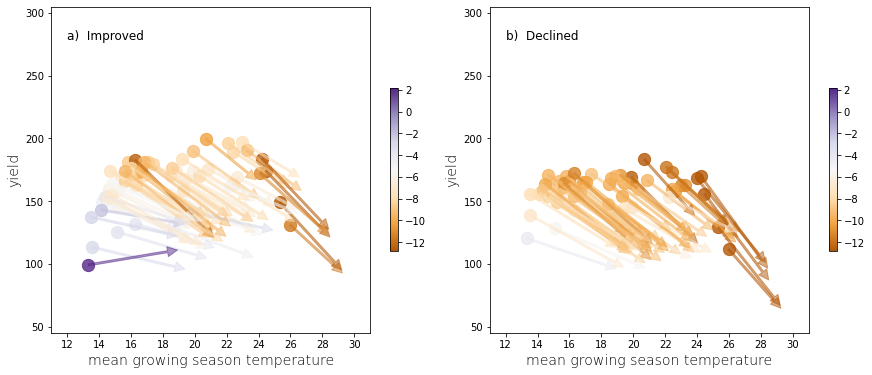

In [23]:
# fetch sensitivity
phenogroups = [phenos_improved, phenos_declined]
sens = fetch_sens(df_all, df_all_f2100, phenogroups)
sens = np.array(sens)
norm = plt.Normalize(sens.min(), sens.max())

phenogroups = [phenos_improved, phenos_declined]
PuOr = plt.get_cmap(PuOr_7.mpl_colormap)
#Magma = plt.get_cmap(Magma_10.mpl_colormap)

alphabets = ['a)  Improved', 'b)  Declined']

fig = plt.figure(figsize=(15,6))
    
for pos, phenos in enumerate(phenogroups):
    ax = fig.add_subplot(1,2,pos+1)
    ax.set_xlim(11,31)
    ax.set_ylim(45,305)

    # visualize
    df_s = df_all[df_all.cvar.isin(phenos)].reset_index(drop=True)
    df_s_present = df_s.copy()[['year','cvar','site','dm_ear','temp','vpd','precip']]

    df_s_f2100 = df_all_f2100[df_all_f2100.cvar.isin(phenos)].reset_index(drop=True)[['year','cvar','site','dm_ear','temp','vpd','precip']]
    df_s_f2100.site = df_s_f2100.site.astype(int)
    df_s_merged = df_s_present.merge(df_s_f2100, how='left', on=['year','cvar','site'])
    df_s_mergedmean = df_s_merged.groupby('site').mean()
    
    # Normalize colors
    xs_present = df_s_mergedmean.temp_x.tolist()
    ys_present = df_s_mergedmean.dm_ear_x.tolist()
    xs_f2100 = df_s_mergedmean.temp_y.tolist()
    ys_f2100 = df_s_mergedmean.dm_ear_y.tolist()

    for item in np.arange(df_s_mergedmean.shape[0]):
        x1 = xs_present[item]
        x2 = xs_f2100[item]
        y1 = ys_present[item]
        y2 = ys_f2100[item]
        sen = (y2-y1)/(x2-x1)
        
        ax.scatter(x1, y1, color=PuOr(norm(sen)), s=150, alpha=0.8)
        ax.scatter(x2, y2, s=0, color=PuOr(norm(sen)))
        ax.annotate('', (x2, y2), 
                    xytext=(x1, y1), 
                    arrowprops=dict(color=PuOr(norm(sen)),
                                    width=2, headwidth=10,
                                    headlength=10, alpha=0.5))


    sc_cmap = plt.scatter(1, 1, c=1, s=0,
                          cmap=PuOr_7.mpl_colormap,
                          vmin=sens.min(), vmax=sens.max())
        
    plt.colorbar(sc_cmap, shrink=0.5)
    ax.set_xticks(np.arange(12,32,2))
    ax.set_xticklabels(np.arange(12,32,2))
    ax.set_xlabel('mean growing season temperature', 
                  fontweight='light', fontsize=14)
    ax.set_ylabel('yield', fontweight='light', fontsize=14)
    ax.annotate(f'{alphabets[pos]}', xy=(0.05, 0.9), 
                xycoords='axes fraction', fontsize=12)
    

fig.subplots_adjust(wspace=0.1)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatterarrows_temp_yield_seqcmap.png', format='png', dpi=800)

In [447]:
n_pheno = 20
w_yield = 1
w_disp = 1
future_run = 'f2100'

top_phenos_present = rank_top_phenos('present', n_pheno, w_yield, w_disp)
top_phenos_future = rank_top_phenos(future_run, n_pheno, w_yield, w_disp)

rank_diffs = []
new_ranks = []
for item, pheno in enumerate(top_phenos_present):
    try:
        new_rank = top_phenos_future.index(pheno)
        new_ranks.append(new_rank)
        rank_diffs.append(item-new_rank)
    except (ValueError):
        new_ranks.append(new_rank)
        rank_diffs.append(np.nan)

df_rankchange = pd.DataFrame({'phenos': top_phenos_present,
                              'rank_change': rank_diffs})
phenos_improved = list(df_rankchange.nlargest(15,'rank_change')['phenos'])
phenos_improved.extend([94])
phenos_declined = list(df_rankchange.nsmallest(10, 'rank_change')['phenos'])
phenos_declined.extend([76,15,87,8])

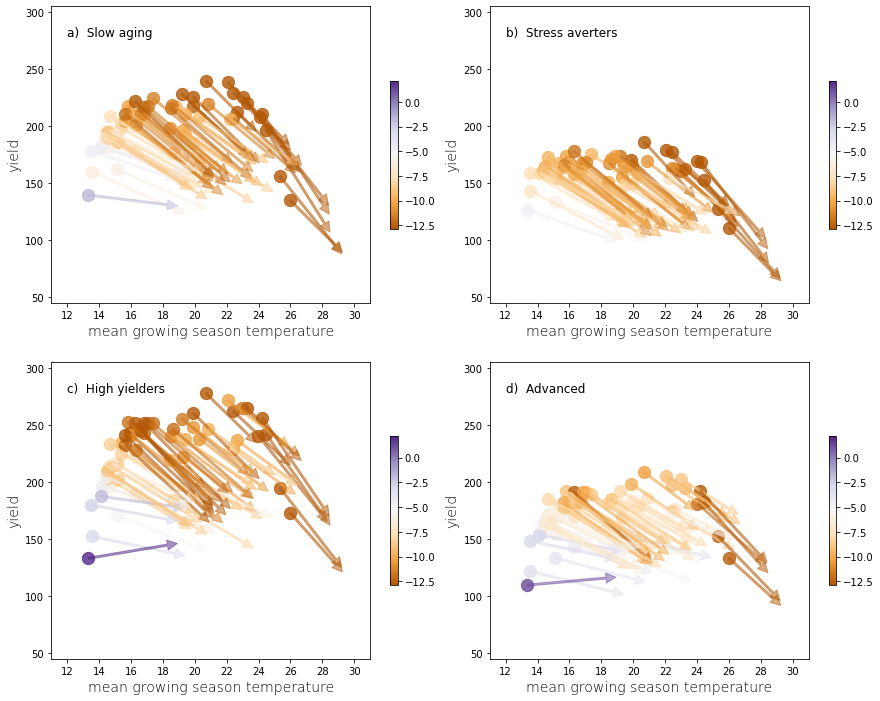

In [24]:
phenogroups = [[46,65,4], [58,62,44], [88,9], [18,12,89,30]]

cmap = plt.get_cmap(PuOr_7.mpl_colormap)
colormap = PuOr_7.mpl_colormap
#cmap = plt.get_cmap(Magma_10.mpl_colormap)
#colormap = Magma_10.mpl_colormap
alphabets = ['a)  Slow aging', 'b)  Stress averters',
             'c)  High yielders', 'd)  Advanced']

fig = plt.figure(figsize=(15,12))
    
for pos, phenos in enumerate(phenogroups):
    ax = fig.add_subplot(2,2,pos+1)
    ax.set_xlim(11,31)
    ax.set_ylim(45,305)

    # visualize
    df_s = df_all[df_all.cvar.isin(phenos)].reset_index(drop=True)
    df_s_present = df_s.copy()[['year','cvar','site','dm_ear','temp','vpd','precip']]

    df_s_f2100 = df_all_f2100[df_all_f2100.cvar.isin(phenos)].reset_index(drop=True)[['year','cvar','site','dm_ear','temp','vpd','precip']]
    df_s_f2100.site = df_s_f2100.site.astype(int)
    df_s_merged = df_s_present.merge(df_s_f2100, how='left', on=['year','cvar','site'])
    df_s_mergedmean = df_s_merged.groupby('site').mean()
    
    # Normalize colors
    xs_present = df_s_mergedmean.temp_x.tolist()
    ys_present = df_s_mergedmean.dm_ear_x.tolist()
    xs_f2100 = df_s_mergedmean.temp_y.tolist()
    ys_f2100 = df_s_mergedmean.dm_ear_y.tolist()

    for item in np.arange(df_s_mergedmean.shape[0]):
        x1 = xs_present[item]
        x2 = xs_f2100[item]
        y1 = ys_present[item]
        y2 = ys_f2100[item]
        sen = (y2-y1)/(x2-x1)
        
        ax.scatter(x1, y1, color=cmap(norm(sen)), s=150, alpha=0.8)
        ax.scatter(x2, y2, s=0, color=cmap(norm(sen)))
        ax.annotate('', (x2, y2), 
                    xytext=(x1, y1), 
                    arrowprops=dict(color=cmap(norm(sen)),
                                    width=2, headwidth=10,
                                    headlength=10, alpha=0.5))


    sc_cmap = plt.scatter(1, 1, c=1, s=0,
                          cmap=colormap,
                          vmin=sens.min(), vmax=sens.max())
        
    plt.colorbar(sc_cmap, shrink=0.5)
    ax.set_xticks(np.arange(12,32,2))
    ax.set_xticklabels(np.arange(12,32,2))
    ax.set_xlabel('mean growing season temperature', 
                  fontweight='light', fontsize=14)
    ax.set_ylabel('yield', fontweight='light', fontsize=14)
    ax.annotate(f'{alphabets[pos]}', xy=(0.05, 0.9), 
                xycoords='axes fraction', fontsize=12)
    

fig.subplots_adjust(wspace=0.1)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatterarrows_temp_yield_seqcmap.png', format='png', dpi=800)

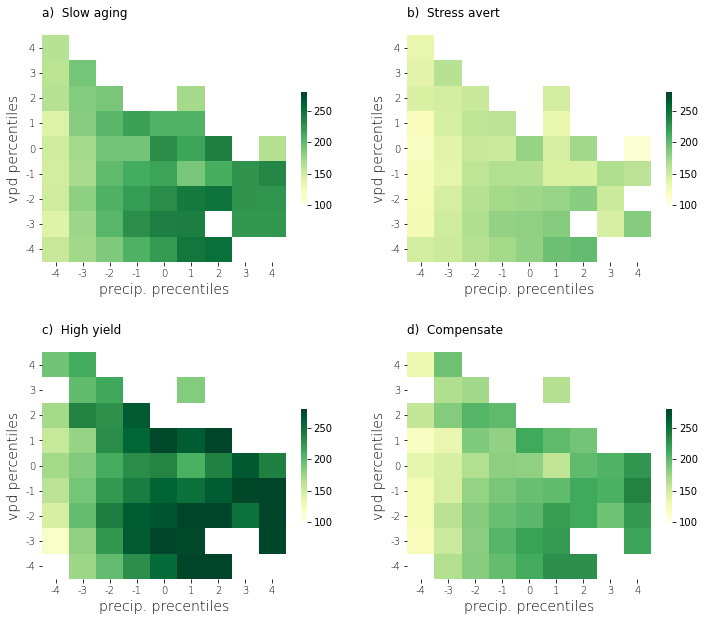

In [72]:
texts = ['a)  Slow aging', 'b)  Stress avert', 
         'c)  High yield', 'd)  Compensate']

n_bins_vpd = 9
n_bins_precip = 9

fig = plt.figure(figsize=(12,10))

for item, phenos in enumerate(phenogroups):
    df_s = df_all[df_all.cvar.isin(phenos)].reset_index(drop=True)

    bins_vpd = pd.cut(df_s.vpd, n_bins_vpd, labels=np.arange(n_bins_vpd).tolist())
    bins_precip = pd.cut(df_s.precip, n_bins_precip, labels=np.arange(n_bins_precip).tolist())
    df_s_present = df_s.copy()[['year','cvar','site','dm_ear']]
    df_s_present['bins_vpd'] = bins_vpd
    df_s_present['bins_precip'] = bins_precip

    df_s_f2100 = df_all_f2100[df_all_f2100.cvar.isin(phenos)].reset_index(drop=True)[['year','cvar','site','dm_ear']]
    df_s_f2100.site = df_s_f2100.site.astype(int)
    df_s_merged = df_s_present.merge(df_s_f2100, how='left', on=['year','cvar','site'])

    
    mx = np.zeros((n_bins_vpd, n_bins_precip))
    for bin_vpd in np.arange(n_bins_vpd):
        for bin_precip in np.arange(n_bins_precip):
            mx[(n_bins_vpd-bin_vpd-1), bin_precip] = df_s_merged.query(
                f'bins_vpd=={bin_vpd}').query(
                f'bins_precip=={bin_precip}').dm_ear_x.mean()

    ax = fig.add_subplot(2,2,item+1)    
    hm = sns.heatmap(mx, cmap=YlGn_9.mpl_colormap,
                     vmin=100, vmax=280,
                     cbar_kws={'shrink': 0.5})

    ax.set_xlabel('precip. precentiles', fontweight='light', fontsize=14)
    ax.set_xticks(np.arange(0.5,9.5))
    ax.set_xticklabels(np.arange(-4,5), fontweight='light')
    ax.set_ylabel('vpd percentiles', fontweight='light', fontsize=14)
    ax.set_yticks(np.arange(0.5,9.5)[::-1])
    ax.set_yticklabels(np.arange(-4,5), fontweight='light', rotation=0)
    ax.annotate(texts[item], xy=(0, 1.08), 
                xycoords='axes fraction', fontsize=12)

fig.subplots_adjust(hspace=0.4)

plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_cspace_yield_precip_vpd.png', format='png', dpi=800)

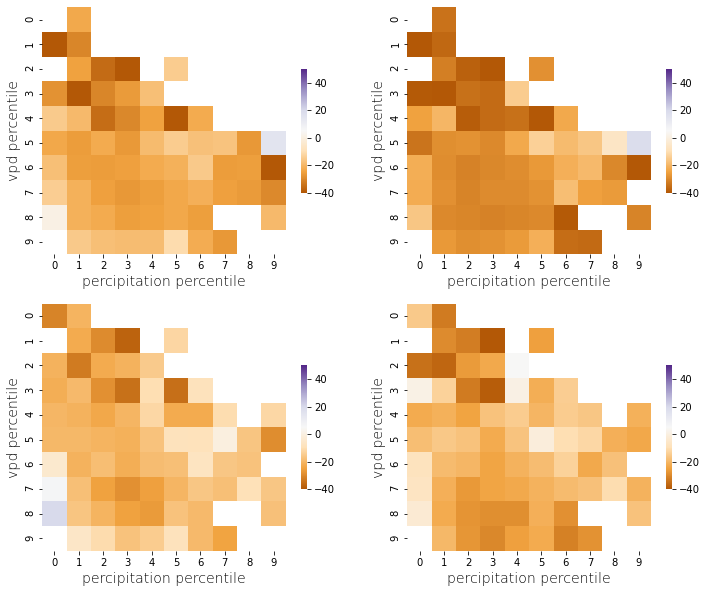

In [82]:
fig = plt.figure(figsize=(12,10))

for item, phenos in enumerate(phenogroups):
    df_s = df_all[df_all.cvar.isin(phenos)].reset_index(drop=True)

    n_bins_vpd = 10
    n_bins_precip = 10

    bins_vpd = pd.cut(df_s.vpd, n_bins_vpd, labels=np.arange(n_bins_vpd).tolist())
    bins_precip = pd.cut(df_s.precip, n_bins_precip, labels=np.arange(n_bins_precip).tolist())
    df_s_present = df_s.copy()[['year','cvar','site','dm_ear']]
    df_s_present['bins_vpd'] = bins_vpd
    df_s_present['bins_precip'] = bins_precip

    df_s_f2100 = df_all_f2100[df_all_f2100.cvar.isin(phenos)].reset_index(drop=True)[['year','cvar','site','dm_ear']]
    df_s_f2100.site = df_s_f2100.site.astype(int)
    df_s_merged = df_s_present.merge(df_s_f2100, how='left', on=['year','cvar','site'])

    
    mx = np.zeros((n_bins_vpd, n_bins_precip))
    for bin_vpd in np.arange(n_bins_vpd):
        for bin_precip in np.arange(n_bins_precip):
            dm_ear_present = df_s_merged.query(
                f'bins_precip=={bin_precip}').query(
                f'bins_vpd=={bin_vpd}').dm_ear_x.mean()
            dm_ear_f2100 = df_s_merged.query(
                f'bins_precip=={bin_precip}').query(
                f'bins_vpd=={bin_vpd}').dm_ear_y.mean()
            mx[(n_bins_vpd-bin_vpd-1), bin_precip] = ((dm_ear_f2100 - dm_ear_present)/dm_ear_present)*100

    ax = fig.add_subplot(2,2,item+1)    
    hm = sns.heatmap(mx, cmap=PuOr_7.mpl_colormap,
                     vmin=-40, vmax=50, cbar_kws={'shrink':0.5})

    ax.set_xlabel('percipitation percentile', fontweight='light', fontsize=14)
    ax.set_ylabel('vpd percentile', fontweight='light', fontsize=14)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_cspace_yieldloss_precip_vpd.png', format='png', dpi=800)

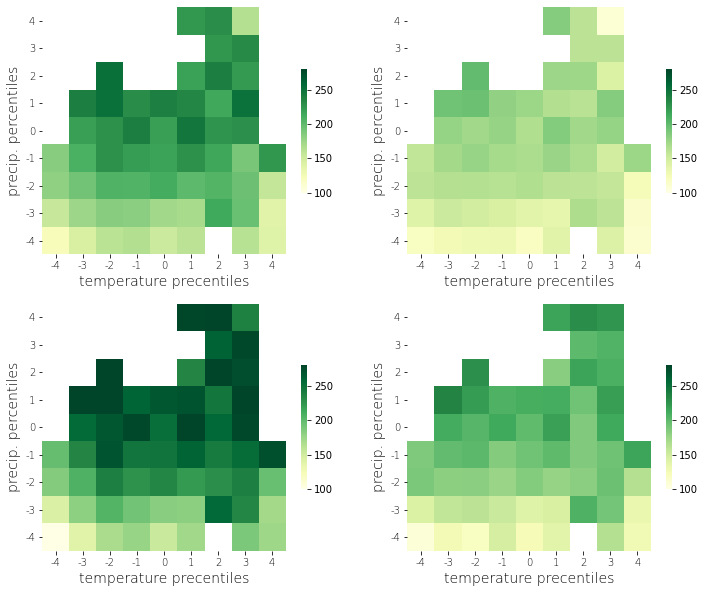

In [234]:
fig = plt.figure(figsize=(12,10))

for item, phenos in enumerate(phenogroups):
    df_s = df_all[df_all.cvar.isin(phenos)].reset_index(drop=True)

    n_bins_temp = 9
    n_bins_precip = 9

    bins_temp = pd.cut(df_s.temp, n_bins_temp, labels=np.arange(n_bins_temp).tolist())
    bins_precip = pd.cut(df_s.precip, n_bins_precip, labels=np.arange(n_bins_precip).tolist())
    df_s_present = df_s.copy()[['year','cvar','site','dm_ear']]
    df_s_present['bins_temp'] = bins_temp
    df_s_present['bins_precip'] = bins_precip

    df_s_f2100 = df_all_f2100[df_all_f2100.cvar.isin(phenos)].reset_index(drop=True)[['year','cvar','site','dm_ear']]
    df_s_f2100.site = df_s_f2100.site.astype(int)
    df_s_merged = df_s_present.merge(df_s_f2100, how='left', on=['year','cvar','site'])

    mx = np.zeros((n_bins_precip, n_bins_temp))
    for bin_precip in np.arange(n_bins_precip):
        for bin_temp in np.arange(n_bins_temp):
            mx[(n_bins_precip-bin_precip-1), bin_temp] = df_s_merged.query(
                f'bins_temp=={bin_temp}').query(
                f'bins_precip=={bin_precip}').dm_ear_x.mean()

    ax = fig.add_subplot(2,2,item+1)    
    hm = sns.heatmap(mx, cmap=YlGn_9.mpl_colormap,
                     vmin=100, vmax=280,
                     cbar_kws={'shrink': 0.5})
    
    ax.set_xlabel('temperature precentiles', fontweight='light', fontsize=14)
    ax.set_xticks(np.arange(0.5,9.5))
    ax.set_xticklabels(np.arange(-4,5), fontweight='light')
    ax.set_ylabel('precip. percentiles', fontweight='light', fontsize=14)
    ax.set_yticks(np.arange(0.5,9.5)[::-1])
    ax.set_yticklabels(np.arange(-4,5), fontweight='light', rotation=0)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_cspace_yield_temp_precip.png', format='png', dpi=800)